In [230]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [231]:
df = pd.read_csv('../../data/process_v1/process_data_6.csv')
df = df[df['city'] == 0]

In [232]:
df['is_street_house'] = (df['accessibility'] == 2).astype(np.int32)

In [233]:
df['landSize_ratio'] = df['landSize'] / df['acreage']

In [234]:
mean_land_size_df = df.groupby('administrative_genre')['landSize'].mean().reset_index().rename(columns = {'landSize': 'meanLandSize'})

df = df.merge(mean_land_size_df, how='left', on = 'administrative_genre')

df['landSize_ratio_with_administrative_genre'] = df['landSize'] / df['meanLandSize']
df['acreage_ratio_with_meanLandSize'] = df['acreage'] / df['meanLandSize']


del df['meanLandSize']

def partition_for_alley_width(alley_width):
    if math.isnan(alley_width):
        return np.nan
    if alley_width <= 2.5:
        return 1
    if alley_width <= 5:
        return 2
    if alley_width <= 7:
        return 3
    if alley_width <= 8:
        return 4
df['type_of_width'] = df['alley_width'].apply(partition_for_alley_width)

In [235]:
{'fitThreeCars': 0,
 'fitOneCarAndOneMotorbike': 1,
 'notInTheAlley': 2,
 'parkCar': 3,
 'theBottleNeckPoint': 4,
 'fitTwoCars': 5,
 'narrorRoad': 6}

{'fitThreeCars': 0,
 'fitOneCarAndOneMotorbike': 1,
 'notInTheAlley': 2,
 'parkCar': 3,
 'theBottleNeckPoint': 4,
 'fitTwoCars': 5,
 'narrorRoad': 6}

In [236]:
cat_cols = ['type_of_width', 'is_street_house', 'ward', 'street', 'district', 'typeOfRealEstate', 'houseDirection', 'accessibility', 'certificateOfLandUseRight'] + [c for c in df.columns.tolist() if '_lat' in c or '_lon' in c]
target_cols = ['target']
remove_cols = ['price', 'description', 'city'] + [c for c in df.columns if 'distance_hcm' in c]
num_cols = [c for c in df.columns.tolist() if c not in (cat_cols + target_cols + remove_cols)]

cat_cols = list(set(cat_cols))
target_cols = list(set(target_cols))
remove_cols = list(set(remove_cols))
num_cols = list(set(num_cols))

print(len(cat_cols), len(target_cols), len(remove_cols), len(num_cols))

29 1 55 154


In [237]:
cat_cols

['nearest_3_lat',
 'nearest_2_lat',
 'typeOfRealEstate',
 'nearest_4_lon',
 'nearest_5_lat',
 'district_lon',
 'nearest_8_lat',
 'nearest_4_lat',
 'nearest_6_lat',
 'nearest_8_lon',
 'street',
 'nearest_5_lon',
 'houseDirection',
 'type_of_width',
 'nearest_6_lon',
 'nearest_1_lat',
 'nearest_0_lat',
 'nearest_0_lon',
 'nearest_2_lon',
 'accessibility',
 'nearest_7_lon',
 'district',
 'certificateOfLandUseRight',
 'nearest_3_lon',
 'nearest_7_lat',
 'ward',
 'nearest_1_lon',
 'district_lat',
 'is_street_house']

In [238]:
num_cols

['num_of_parking_in_2000m_radius',
 'distance_nearest_7',
 'distance_nearest_3',
 'distance_hn_Vườn hoa Lý Thái Tổ',
 'num_of_school_in_2000m_radius',
 'distance_hn_Hồ Tây 3',
 'num_of_fast_food_in_1000m_radius',
 'nearest_3_street',
 'distance_hn_Lotte Center Hanoi',
 'num_of_townhall - community_centre_in_1000m_radius',
 'distance_hn_Trung tâm thương mại Hà Nội Center Point',
 'distance_hn_Hồ Ngọc Khánh',
 'distance_nearest_5',
 'num_of_bank_in_500m_radius',
 'landSize_ratio_with_administrative_genre',
 'num_of_police_in_1000m_radius',
 'num_of_place_of_worship_in_2000m_radius',
 'num_of_cafe_in_500m_radius',
 'nearest_0_ward',
 'nearest_5_district',
 'distance_hn_Vườn hoa Lênin',
 'num_of_parking_in_500m_radius',
 'distance_hn_Công viên thống nhất',
 'nearest_1_ward',
 'landSize_ratio',
 'nearest_7_street',
 'administrative_genre',
 'distance_hn_Hàng Trống',
 'num_of_hospital_in_500m_radius',
 'distance_hn_Hồ Tây 4',
 'population',
 'facade',
 'num_of_bank_in_1000m_radius',
 'distan

In [239]:
print(len(num_cols))

154


In [240]:
train_independent_corr = df[num_cols].corr()
train_seleted_corr_columns = np.full((train_independent_corr.shape[0],), True, dtype=bool)
for i in range(train_independent_corr.shape[0]):
    for j in range(i + 1, train_independent_corr.shape[0]):
        if train_independent_corr.iloc[i, j] >= 0.99:

            if train_seleted_corr_columns[j]:
                train_seleted_corr_columns[j] = False
train_selected_columns = df[num_cols].columns[train_seleted_corr_columns]
print(train_selected_columns.shape)

(135,)


In [241]:
# train_selected_columns = list(train_selected_columns)
train_selected_columns = num_cols

In [242]:
df[cat_cols] = df[cat_cols].fillna(100)
df[cat_cols] = df[cat_cols].astype(np.int32)

In [243]:
df = df[cat_cols + num_cols + target_cols]

In [245]:
df = df[df[target_cols[0]] != np.inf]
df = df[df[target_cols[0]] != -np.inf]

In [246]:
df.shape

(121911, 184)

In [247]:
df = df[df[target_cols[0]] >= 10]
df = df[df[target_cols[0]] < 100 * 10]
# df = pd.concat([df[df['w'] < 50], df[df['w'].isnull()]])
# df = pd.concat([df[df['h'] < 50], df[df['w'].isnull()]])

In [ ]:
df.to_csv('../../data/process_v1/process_data_7.csv', index = False)

In [248]:
categorical_features_indices = [i for i, c in enumerate(df.columns.tolist()) if c in cat_cols]

In [249]:
X = df.drop(target_cols[0], axis=1)
y = df[target_cols[0]] / 100

In [250]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.9, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(98580, 183) (98580,)
(10954, 183) (10954,)


In [251]:
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score

In [252]:
model = CatBoostRegressor(verbose=100, iterations = 5000, task_type='GPU', devices = '0:1')
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    logging_level='Verbose',
    # plot=True
)

Learning rate set to 0.064452
0:	learn: 1.2225420	test: 1.2110656	best: 1.2110656 (0)	total: 24.8ms	remaining: 2m 4s
100:	learn: 0.5877189	test: 0.5801429	best: 0.5801429 (100)	total: 2.33s	remaining: 1m 53s
200:	learn: 0.5633429	test: 0.5614675	best: 0.5614675 (200)	total: 4.58s	remaining: 1m 49s
300:	learn: 0.5495434	test: 0.5526171	best: 0.5526171 (300)	total: 6.86s	remaining: 1m 47s
400:	learn: 0.5391315	test: 0.5476041	best: 0.5476041 (400)	total: 9.15s	remaining: 1m 44s
500:	learn: 0.5311424	test: 0.5435904	best: 0.5435904 (500)	total: 11.5s	remaining: 1m 43s
600:	learn: 0.5235053	test: 0.5404938	best: 0.5404938 (600)	total: 13.8s	remaining: 1m 40s
700:	learn: 0.5169086	test: 0.5375406	best: 0.5375406 (700)	total: 16.1s	remaining: 1m 38s
800:	learn: 0.5110126	test: 0.5350959	best: 0.5350959 (800)	total: 18.4s	remaining: 1m 36s
900:	learn: 0.5059127	test: 0.5331859	best: 0.5331859 (900)	total: 20.7s	remaining: 1m 34s
1000:	learn: 0.5012736	test: 0.5314973	best: 0.5314973 (1000)	to

In [253]:
feature_importances = pd.DataFrame(model.get_feature_importance(),columns=['importance'])
feature = pd.DataFrame(df.columns,columns=['feature'])
feature_importance_df = pd.concat([feature_importances,feature],axis=1)
feature_importance_df[feature_importance_df['importance'] == 0]

,importance,feature
3,0.0,nearest_4_lon
5,0.0,district_lon
9,0.0,nearest_8_lon
11,0.0,nearest_5_lon
14,0.0,nearest_6_lon
16,0.0,nearest_0_lat
17,0.0,nearest_0_lon
18,0.0,nearest_2_lon
20,0.0,nearest_7_lon
38,0.0,num_of_townhall - community_centre_in_1000m_ra...


In [254]:
feature_importance_df[feature_importance_df['feature'] == 'alley_width']

,importance,feature
66,0.015085,alley_width


Text(0.5, 1.0, 'Feature Importances ')

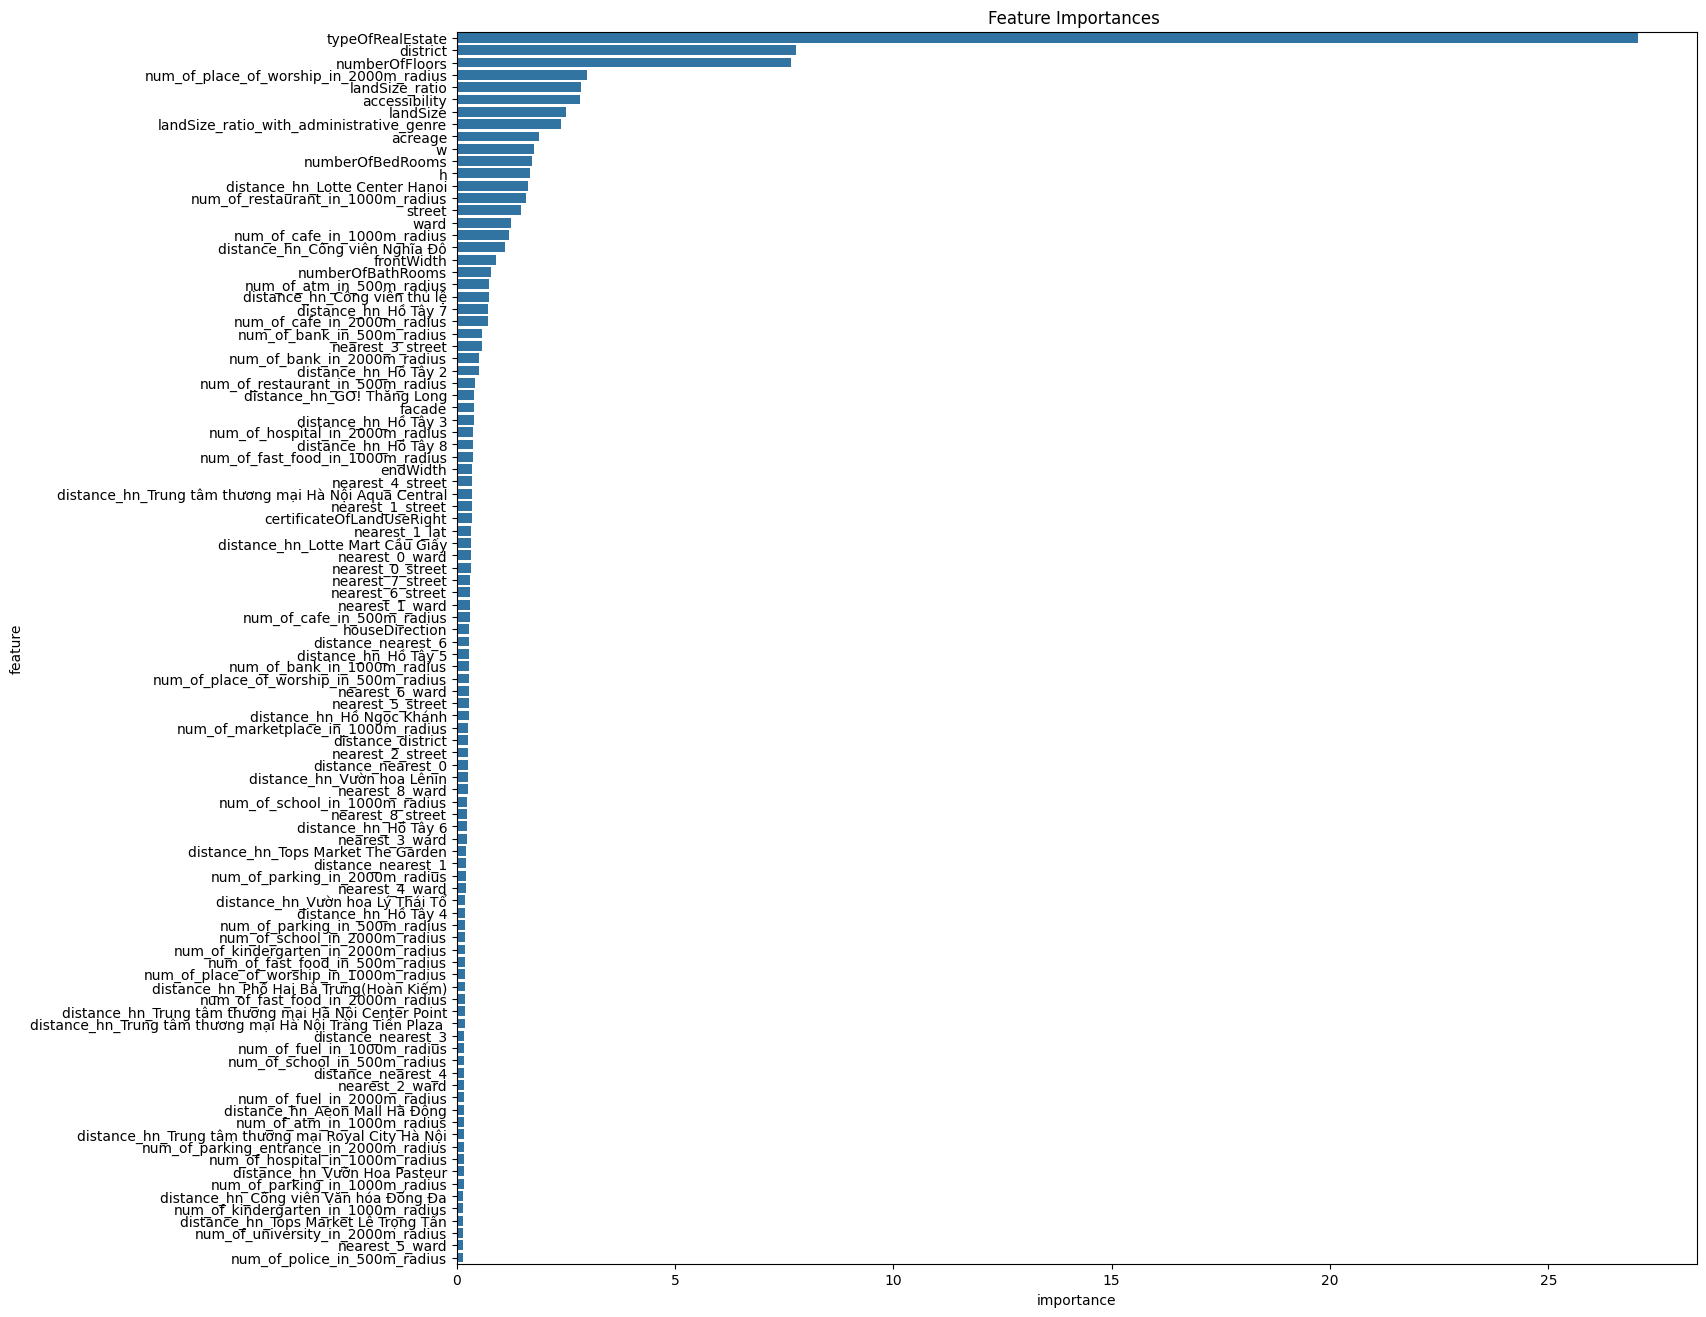

In [255]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance_df.sort_values(by='importance', ascending=False).head(100), x='importance', y='feature')
plt.title('Feature Importances ')

In [256]:
val_pred_df = pd.DataFrame()
val_pred_df['pred'] = model.predict(X_validation)
val_pred_df['target'] = y_validation


In [257]:
val_pred_df

,pred,target
0,3.521708,NaN
1,0.804012,NaN
2,3.637848,NaN
3,2.688447,NaN
4,0.468916,NaN
...,...,...
10949,2.454343,NaN
10950,0.396382,NaN
10951,0.761910,NaN
10952,0.504460,NaN


/tmp/ipykernel_1148732/2592398615.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=val_pred_df['target'], color='blue', kde=True)
/tmp/ipykernel_1148732/2592398615.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=val_pred_df['pred'], color='red', kde=True)


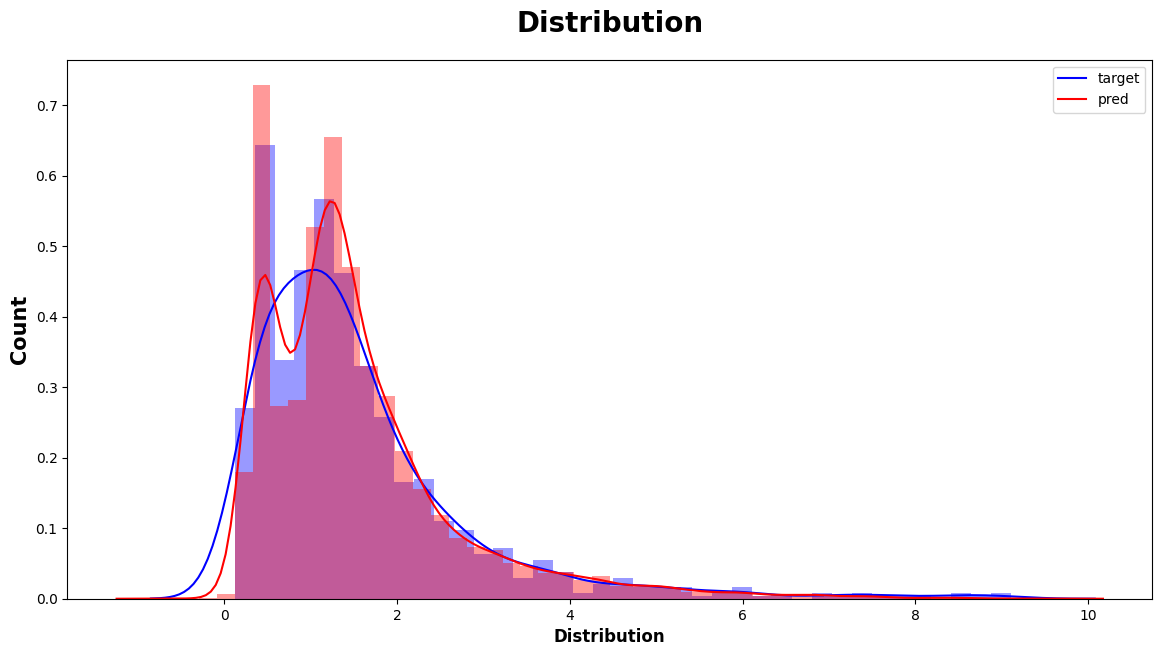

In [258]:
def plot_distribution():
    plt.subplots(figsize=(14,7))
    sns.distplot(x=val_pred_df['target'], color='blue', kde=True)
    sns.distplot(x=val_pred_df['pred'], color='red', kde=True)
    plt.title("Distribution", weight="bold",fontsize=20, pad=20)
    plt.ylabel("Count", weight="bold", fontsize=15)
    plt.xlabel(f'Distribution', weight="bold", fontsize=12)
    plt.legend(['target', 'pred'])
    plt.show()
plot_distribution()